In [ ]:
"""
Deep learning modeling of tomato leaf disease detection
Data were taken from : https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
-- Convolutional neural network (CNN) and data agumentaion has been tested for tomato disease detection
--  Transfer learning with MobileNetV2 model has been used for tomato leaf disease calssification 
"""

In [114]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPool2D
from sklearn.metrics import classification_report

# Create dataset of tomato images using Tensorflow.Dataset 

In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
dataset=keras.preprocessing.image_dataset_from_directory(
    "data",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
    seed=100
)

Found 11000 files belonging to 10 classes.


In [10]:
classes=dataset.class_names
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [12]:
for images,labels in dataset.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[6 8 4 6 3 9 0 1 2 9 6 9 9 3 7 2 9 1 4 8 4 8 5 2 6 4 2 0 4 0 1 2]


2024-09-02 15:19:00.139529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 328 of 1000
2024-09-02 15:19:02.115963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


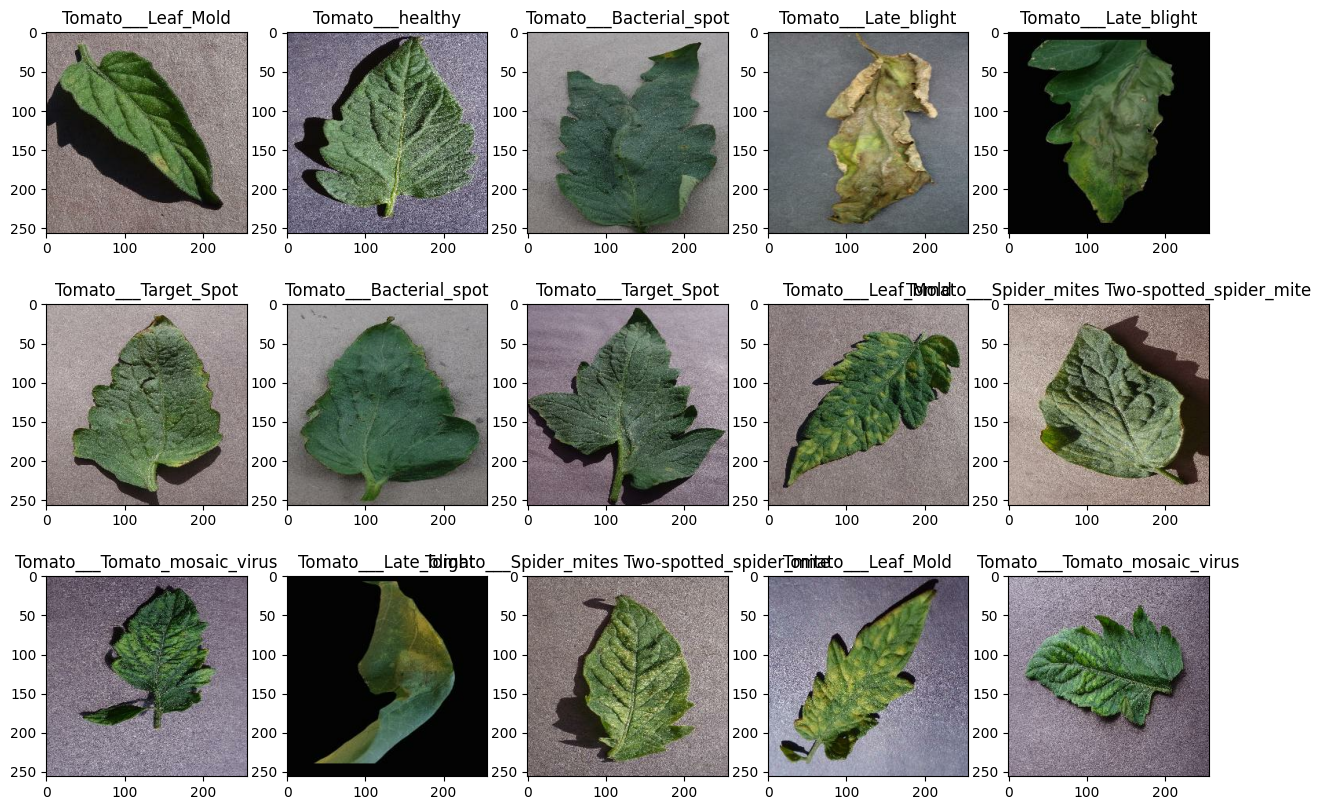

In [21]:
plt.figure(figsize=(15,10))
for images,labels in dataset.take(1):
    for i in range (0,15):
         ax=plt.subplot(3,5,i+1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(classes[labels[i].numpy()])

In [18]:
shuffle_size = 1000
dataset = dataset.shuffle(shuffle_size, seed=100)
train_ds=dataset.take(int(0.8*len(dataset)))
val_ds=dataset.skip(int(0.8*len(dataset))).take(int(0.1*len(dataset)))
test_ds=dataset.skip(int(0.8*len(dataset))).skip(int(0.1*len(dataset)))

In [26]:
for images,labels in train_ds.take(1):
    print(len(images))
    print(labels)

32
tf.Tensor([6 6 1 6 3 1 4 8 9 4 1 3 4 8 5 1 8 7 0 8 4 1 7 1 2 9 9 8 9 1 1 9], shape=(32,), dtype=int32)


In [19]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(500)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(500)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(500)

# Convolutional neural network (CNN) and data agumentaion for tomato disease classification

In [22]:
Resize_Rescale=keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1/255)
])

In [23]:
data_agumentation=keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomContrast(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [24]:
model=keras.Sequential([
    Resize_Rescale,
    data_agumentation,

    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3)

Epoch 1/3
275/275 [==============================] - ETA: 0s - loss: 1.7184 - accuracy: 0.3599

2024-09-02 15:28:41.950097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 151 of 1000
2024-09-02 15:28:51.945470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 284 of 1000
2024-09-02 15:28:57.511130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-09-02 15:28:59.339097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


275/275 [==============================] - 510s 2s/step - loss: 1.7184 - accuracy: 0.3599 - val_loss: 2.4711 - val_accuracy: 0.3199
Epoch 2/3
275/275 [==============================] - 487s 2s/step - loss: 1.1911 - accuracy: 0.5796 - val_loss: 3.3907 - val_accuracy: 0.3732
Epoch 3/3
275/275 [==============================] - 62090s 227s/step - loss: 0.8960 - accuracy: 0.6803 - val_loss: 2.1786 - val_accuracy: 0.5028


In [28]:
model.evaluate(test_ds)

2024-09-03 11:32:17.744431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 248 of 1000
2024-09-03 11:32:22.293916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-09-03 11:32:24.432872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


35/35 [==============================] - 28s 325ms/step - loss: 2.0961 - accuracy: 0.5081


[2.0960545539855957, 0.508093535900116]

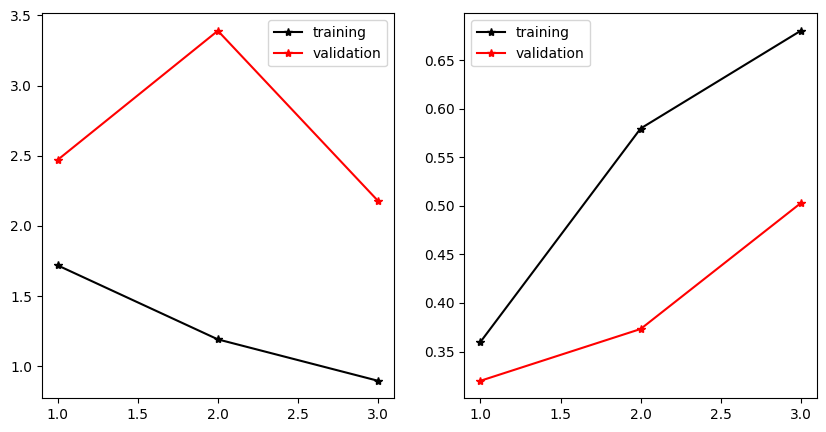

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,4),history.history['loss'],color='black',label='training', marker='*')
plt.plot(np.arange(1,4),history.history['val_loss'],color='red',label='validation', marker='*')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(1,4),history.history['accuracy'],color='black',label='training', marker='*')
plt.plot(np.arange(1,4),history.history['val_accuracy'],color='red',label='validation', marker='*')
plt.legend()

In [30]:
for images,labels in test_ds.take(1):
        ypred=model.predict(images)
        ypred=[np.argmax(i) for i in ypred]
        print(f"predicted labels:{ypred}")
        print(f"actual labels:{labels}")

1/1 [==============================] - 1s 747ms/step
predicted labels:[8, 1, 3, 3, 9, 1, 2, 5, 3, 1, 8, 3, 6, 6, 8, 8, 1, 0, 8, 7, 3, 9, 7, 5, 9, 8, 1, 2, 8, 3, 5, 0]
actual labels:[6 1 1 3 9 2 2 4 2 2 8 1 5 6 8 8 0 0 8 7 4 5 7 2 9 7 0 3 7 9 0 0]


1/1 [==============================] - 0s 406ms/step


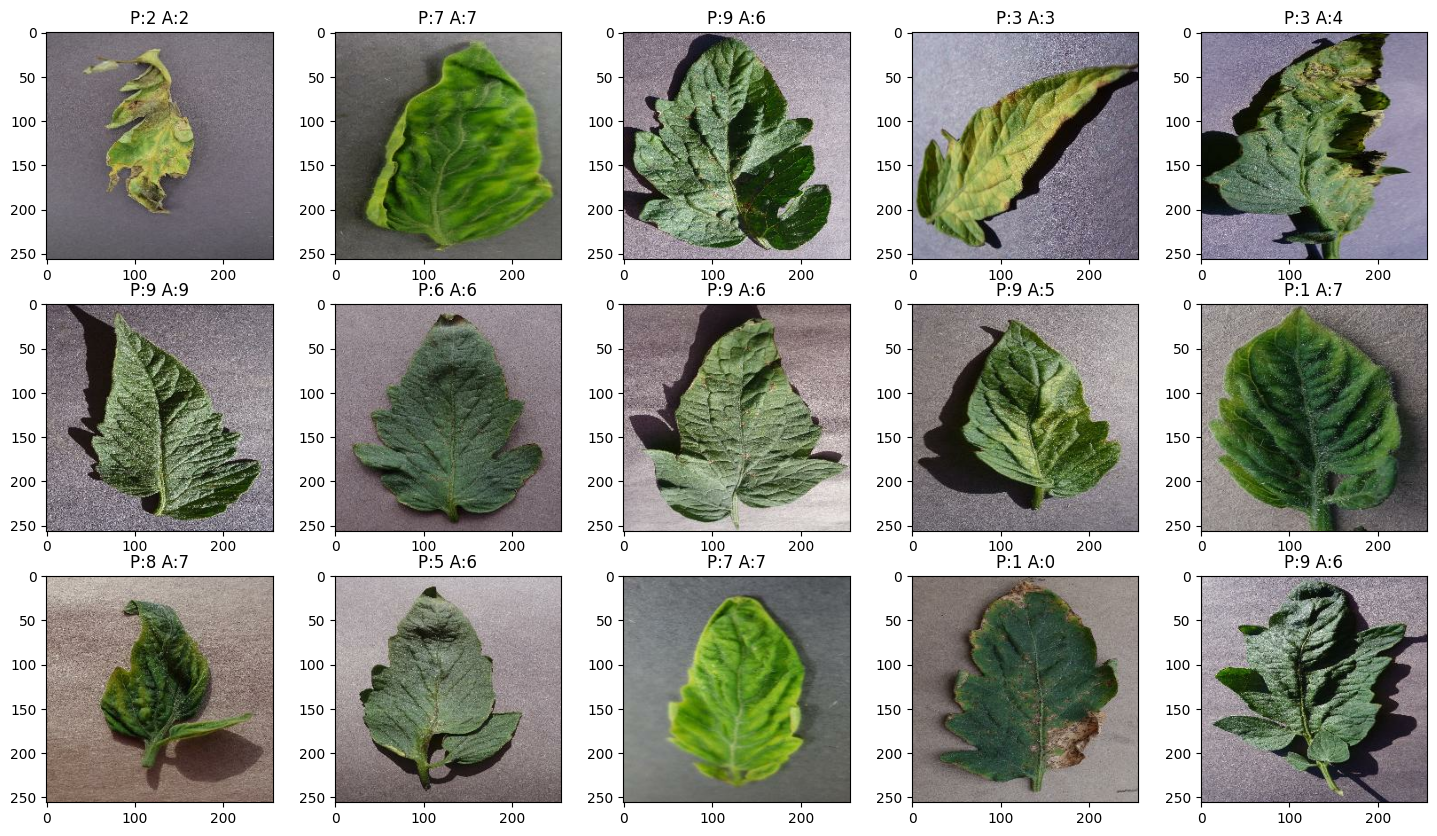

In [31]:
plt.figure(figsize=(18,10))
for images,labels in test_ds.take(1):
    ypred=model.predict(images)
    ypred=[np.argmax(i) for i in ypred]
    for i in range (0,15):
         ax=plt.subplot(3,5,i+1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(f"P:{ypred[i]} A:{labels[i].numpy()}")        

In [32]:
model.save("model.pkl")

INFO:tensorflow:Assets written to: model.pkl/assets


INFO:tensorflow:Assets written to: model.pkl/assets


In [109]:
ypred_tot=[]
label_tot=[]
for images, labels in test_ds:
    ypred_test=model.predict(images)
    ypred_test=[np.argmax(i) for i in ypred_test]
    ypred_tot.extend(ypred_test)
    label_tot.extend(labels.numpy())

1/1 [==============================] - 0s 342ms/step


<Axes: >

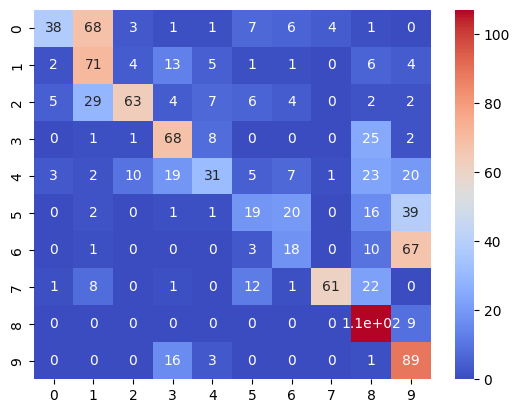

In [112]:
cm=tf.math.confusion_matrix(label_tot,ypred_tot)
sns.heatmap(cm, annot=True, cmap="coolwarm")

In [115]:
print(classification_report(label_tot,ypred_tot))

              precision    recall  f1-score   support

           0       0.78      0.29      0.43       129
           1       0.39      0.66      0.49       107
           2       0.78      0.52      0.62       122
           3       0.55      0.65      0.60       105
           4       0.55      0.26      0.35       121
           5       0.36      0.19      0.25        98
           6       0.32      0.18      0.23        99
           7       0.92      0.58      0.71       106
           8       0.50      0.92      0.65       116
           9       0.38      0.82      0.52       109

    accuracy                           0.51      1112
   macro avg       0.55      0.51      0.48      1112
weighted avg       0.56      0.51      0.49      1112



# Transfer Learning of tomato leaf disease calssification with MobileNet model

In [134]:
base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                                   include_top=False,
                                                   weights='imagenet')
base_model.trainable = False                                             

def MobileNet_model():
    inputs = tf.keras.Input(shape=(256,256,3))
    Resizing=keras.layers.experimental.preprocessing.Resizing(224,224)(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(Resizing) 
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    output = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs = output)
     
    model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    return model

In [135]:
model=MobileNet_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [136]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3)

Epoch 1/3


275/275 [==============================] - 303s 1s/step - loss: 1.1735 - accuracy: 0.6201 - val_loss: 0.6854 - val_accuracy: 0.7904
Epoch 2/3
275/275 [==============================] - 248s 900ms/step - loss: 0.6571 - accuracy: 0.7912 - val_loss: 0.4891 - val_accuracy: 0.8529
Epoch 3/3
275/275 [==============================] - 250s 908ms/step - loss: 0.5434 - accuracy: 0.8243 - val_loss: 0.4225 - val_accuracy: 0.8667


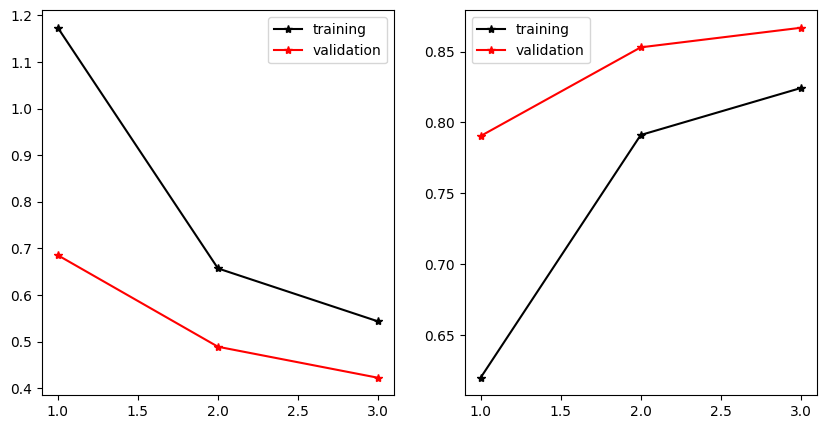

In [137]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.arange(1,4),history.history['loss'],color='black',label='training', marker='*')
plt.plot(np.arange(1,4),history.history['val_loss'],color='red',label='validation', marker='*')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(1,4),history.history['accuracy'],color='black',label='training', marker='*')
plt.plot(np.arange(1,4),history.history['val_accuracy'],color='red',label='validation', marker='*')
plt.legend()

In [138]:
model.save("tf_model.h5")

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [140]:
model.evaluate(test_ds)

35/35 [==============================] - 36s 986ms/step - loss: 0.4283 - accuracy: 0.8606


[0.4283466041088104, 0.8606114983558655]

In [141]:
ypred_tot=[]
label_tot=[]
for images, labels in test_ds:
    ypred_test=model.predict(images)
    ypred_test=[np.argmax(i) for i in ypred_test]
    ypred_tot.extend(ypred_test)
    label_tot.extend(labels.numpy())

1/1 [==============================] - 1s 926ms/step


<Axes: >

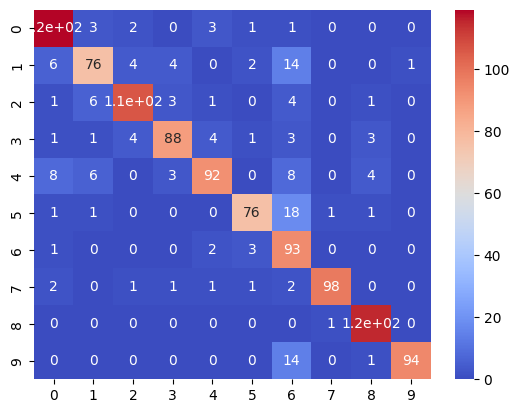

In [142]:
cm=tf.math.confusion_matrix(label_tot,ypred_tot)
sns.heatmap(cm, annot=True, cmap="coolwarm")

In [145]:
print(classification_report(label_tot,ypred_tot))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       129
           1       0.82      0.71      0.76       107
           2       0.91      0.87      0.89       122
           3       0.89      0.84      0.86       105
           4       0.89      0.76      0.82       121
           5       0.90      0.78      0.84        98
           6       0.59      0.94      0.73        99
           7       0.98      0.92      0.95       106
           8       0.92      0.99      0.95       116
           9       0.99      0.86      0.92       109

    accuracy                           0.86      1112
   macro avg       0.87      0.86      0.86      1112
weighted avg       0.88      0.86      0.86      1112

